In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_score
import hashlib

In [14]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.transformers = {}
        self.feature_types = {}
        
    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.
        """
        self.feature_types = params
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue
                
            if transform_type == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[feature]])
                self.transformers[feature] = scaler
                
            elif transform_type == "ordinal":
                encoder = OrdinalEncoder()
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
            elif transform_type == "onehot":
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoder.fit(df[[feature]])
                self.transformers[feature] = encoder
                
    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features and returns a NumPy array."""
        transformed_features = []
        
        for feature, transform_type in self.feature_types.items():
            if feature not in df.columns:
                continue

            transformer = self.transformers[feature]
            transformed = transformer.transform(df[[feature]])
      
            if len(transformed.shape) == 2 and transformed.shape[1] > 1:
                transformed_features.append(transformed)
            else:
                transformed_features.append(transformed.reshape(-1, 1))
                
        return np.concatenate(transformed_features, axis=1)
    
    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step using the given transformation parameters."""
        self.fit(df, params)
        return self.transform(df)

In [ ]:
class KMeans:
    """
    Our custom K-Means clustering implementation.
    """
    def __init__(self, k, max_iters=100, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.cost = None
        self.labels_ = None 

    def _euclidean_distance(self, point1, point2):
        """Calculates the squared Euclidean distance between two points."""
        return np.sum((point1 - point2)**2)

    def fit(self, X):
        """Fits the K-Means model to the data."""
        n_samples, n_features = X.shape
        np.random.seed(self.random_state)
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iters):
            clusters = [[] for _ in range(self.k)]
            for point in X:
                distances = [self._euclidean_distance(point, centroid) for centroid in self.centroids]
                closest_centroid_idx = np.argmin(distances)
                clusters[closest_centroid_idx].append(point)
            old_centroids = self.centroids.copy()
            for i in range(self.k):
                if clusters[i]:
                    self.centroids[i] = np.mean(clusters[i], axis=0)
            if np.all(self.centroids == old_centroids):
                break
        
        self.labels_ = self.predict(X)
        self._calculate_cost(X)

    def predict(self, X):
        """Assigns each data point to the nearest centroid."""
        if self.centroids is None:
            raise RuntimeError("Model has not been fitted yet.")
        
        labels = []
        for point in X:
            distances = [self._euclidean_distance(point, centroid) for centroid in self.centroids]
            closest_centroid_idx = np.argmin(distances)
            labels.append(closest_centroid_idx)
        return np.array(labels)

    def _calculate_cost(self, X):
        """Calculates the total cost (WCSS) of the clustering."""
        self.cost = 0
        for i, point in enumerate(X):
            assigned_centroid = self.centroids[self.labels_[i]]
            self.cost += self._euclidean_distance(point, assigned_centroid)

    def getCost(self):
        """Returns the total cost (WCSS) of the clustering."""
        if self.cost is None:
            raise RuntimeError("Cost is not available.")
        return self.cost

In [ ]:
class CustomerSegmenter:
    """
    Manages the customer segmentation analysis from loading data to visualization.
    """
    def __init__(self, file_path, username):
        self.username = username
        self.seed = abs(hash(self.username)) % (2**32)
        self.data = pd.read_csv(file_path)
        self.scaled_features = None
        self.feature_transformer = PerFeatureTransformer()

    def _watermark(self, ax):
        """Adds a watermark with the username to the plot."""
        ax.text(0.98, 0.98, self.username, ha='right', va='top', transform=ax.transAxes, fontsize=10, color='gray', alpha=0.6)

    def preprocess(self):
        """Handle NaNs and scale features"""
        df_cleaned = self.data.copy()
        df_cleaned.dropna(thresh=df_cleaned.shape[1] - 1, inplace=True)
        df_cleaned.dropna(subset=['Genre'], inplace=True)
        numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
        median_values = df_cleaned[numeric_cols].median()
        df_cleaned.fillna(median_values, inplace=True)

        transform_params = {
            'Annual Income (k$)': 'standard',
            'Spending Score (1-100)': 'standard', 
            'Age': 'standard',
            'Genre': 'onehot'
        }
    
        self.scaled_features = self.feature_transformer.fit_transform(df_cleaned, transform_params)
       

    def analyze_optimal_k(self, max_k=20):
        """Runs both Elbow and Silhouette methods."""
        k_range = range(2, max_k + 1)
        wcss = []
        silhouette_scores = []
        for k in k_range:
            kmeans = KMeans(k=k, random_state=self.seed)
            kmeans.fit(self.scaled_features)            
            wcss.append(kmeans.getCost())
            score = silhouette_score(self.scaled_features, kmeans.labels_)
            silhouette_scores.append(score)
        optimal_k = k_range[np.argmax(silhouette_scores)]
        return optimal_k, wcss, silhouette_scores
    
    def plot_elbow_silhouette(self, wcss, silhouette_scores, max_k=20):
        """Plots the Elbow and Silhouette methods."""
        k_range = range(2, max_k + 1)
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(k_range, wcss, marker='o', label='Elbow Method (WCSS)', color='blue')
        ax1.set_xlabel('Number of clusters (k)')
        ax1.set_ylabel('WCSS')
        ax1.set_title('Elbow Method for Optimal k')
        ax1.grid(True)
        self._watermark(ax1)

        fig, ax2 = plt.subplots(figsize=(12, 6))
        ax2.plot(k_range, silhouette_scores, marker='s', label='Silhouette Score', color='orange')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_xlabel('Number of clusters (k)')
        ax2.set_title('Silhouette Method for Optimal k')
        ax2.grid(True)
        self._watermark(ax2)
        plt.tight_layout()
        plt.show()

    def run_pipeline(self):
        """Runs the full customer segmentation pipeline."""
        self.preprocess()
        optimal_k, wcss, silhouette_scores = self.analyze_optimal_k()
        self.plot_elbow_silhouette(wcss, silhouette_scores, max_k=20)


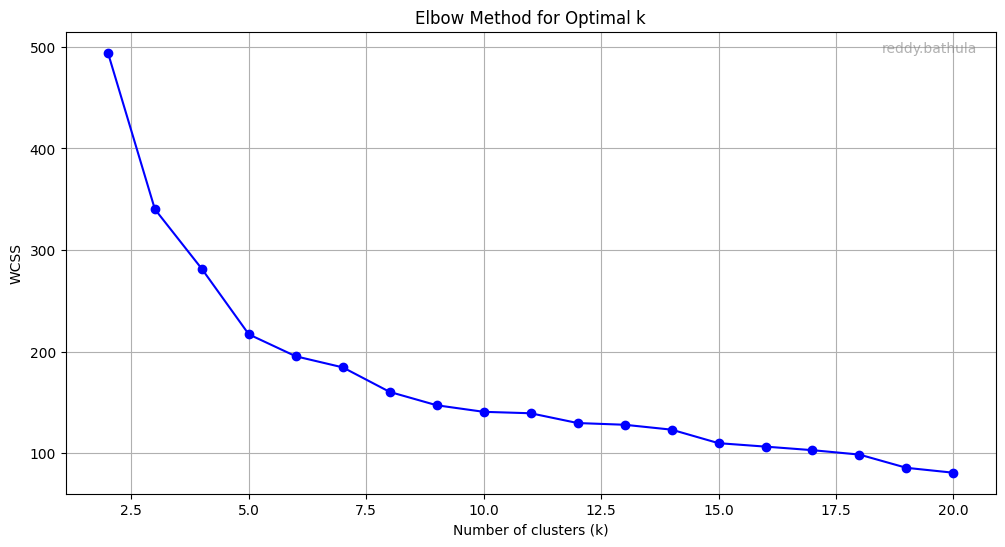

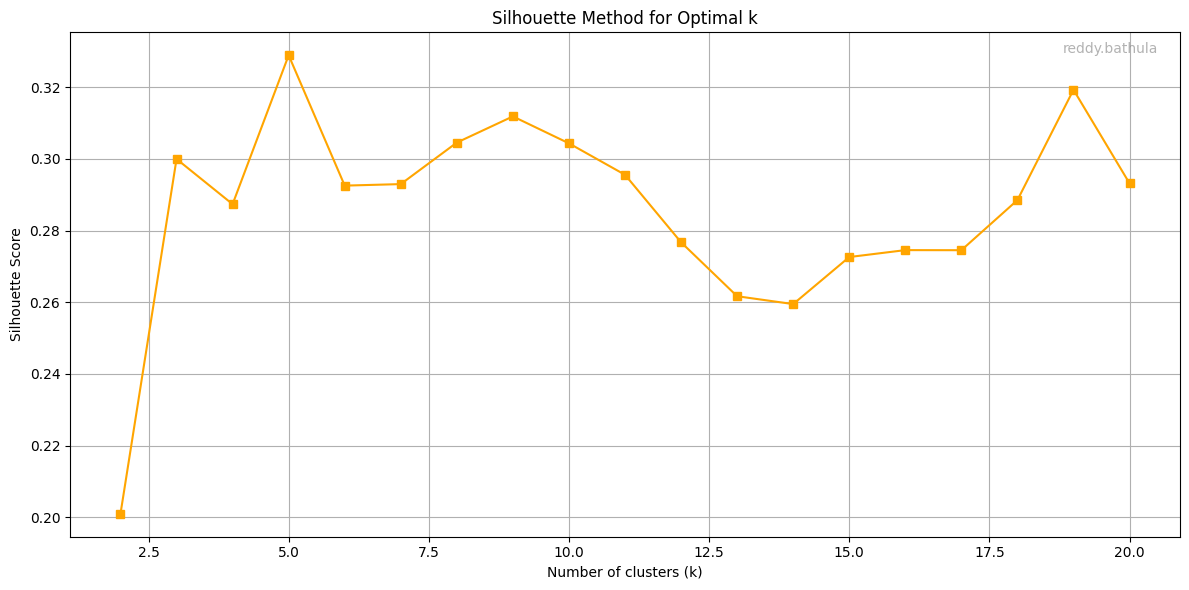

In [58]:
username = "reddy.bathula"
file_path = 'Dataset/Clustering_dataset.csv'
segmenter = CustomerSegmenter(file_path=file_path, username=username)
segmenter.run_pipeline()

### Elbow Method:

    - The WCSS (Within-Cluster Sum of Squares) decreases sharply from k = 2 → 4, then the rate of decrease slows down significantly after k ≈ 4 or 5.

    - This point where the curve bends and starts to flatten is called the “elbow.”

    - After k = 5, the improvement in WCSS becomes much smaller for each additional cluster, suggesting diminishing returns.

### Silhouette Method:

    - The silhouette score peaks at k = 5, with a value slightly above 0.33.

    - At optimal K, clusters are relatively compact and separated better compared to other values of k. However, the score (~0.33) is moderate — suggesting that while clusters are distinguishable, they are not perfectly separated.

    - This could imply:
        - Some clusters overlap slightly.

        - The dataset has some natural grouping but not very strong boundaries.

        - Adding more clusters beyond 5 doesn’t improve separation significantly (scores decline or stay lower).
